# Ranking the Sensor based on its Predictive Power

Ranking the Sensor based on its importance/predictive power
with respect to the class labels of the samples is similar to rank the features of a dataset based on its important to prodict the correct output.



# Data Preparation

In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
%pylab inline

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV, SelectKBest

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

import warnings; warnings.simplefilter('ignore')

Populating the interactive namespace from numpy and matplotlib


In [30]:
df = pd.read_csv('task_data.csv')

In [31]:
df.head()

,sample index,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
0,sample0,1.0,0.834251,0.726081,0.535904,0.214896,0.873788,0.767605,0.111308,0.557526,0.599650,0.665569
1,sample1,1.0,0.804059,0.253135,0.869867,0.334285,0.604075,0.494045,0.833575,0.194190,0.014966,0.802918
2,sample2,1.0,0.694404,0.595777,0.581294,0.799003,0.762857,0.651393,0.075905,0.007186,0.659633,0.831009
3,sample3,1.0,0.783690,0.038780,0.285043,0.627305,0.800620,0.486340,0.827723,0.339807,0.731343,0.892359
4,sample4,1.0,0.788835,0.174433,0.348770,0.938244,0.692065,0.377620,0.183760,0.616805,0.492899,0.930969


In [32]:
df = df.drop(['sample index'], axis = 1)
df.head()

,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
0,1.0,0.834251,0.726081,0.535904,0.214896,0.873788,0.767605,0.111308,0.557526,0.599650,0.665569
1,1.0,0.804059,0.253135,0.869867,0.334285,0.604075,0.494045,0.833575,0.194190,0.014966,0.802918
2,1.0,0.694404,0.595777,0.581294,0.799003,0.762857,0.651393,0.075905,0.007186,0.659633,0.831009
3,1.0,0.783690,0.038780,0.285043,0.627305,0.800620,0.486340,0.827723,0.339807,0.731343,0.892359
4,1.0,0.788835,0.174433,0.348770,0.938244,0.692065,0.377620,0.183760,0.616805,0.492899,0.930969


In [33]:
df.describe()

,class_label,sensor0,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.000000,0.523661,0.509223,0.481238,0.509752,0.497875,0.501065,0.490480,0.482372,0.482822,0.541933
std,1.001252,0.268194,0.276878,0.287584,0.297712,0.288208,0.287634,0.289954,0.282714,0.296180,0.272490
min,-1.000000,0.007775,0.003865,0.004473,0.001466,0.000250,0.000425,0.000173,0.003322,0.003165,0.000452
25%,-1.000000,0.299792,0.283004,0.235544,0.262697,0.249369,0.269430,0.226687,0.242848,0.213626,0.321264
50%,0.000000,0.534906,0.507583,0.460241,0.510066,0.497842,0.497108,0.477341,0.463438,0.462251,0.578389
75%,1.000000,0.751887,0.727843,0.734937,0.768975,0.743401,0.738854,0.735304,0.732483,0.740542,0.768990
max,1.000000,0.999476,0.998680,0.992963,0.995119,0.999412,0.997367,0.997141,0.998230,0.996098,0.999465


In [34]:
df.isnull().sum()

class_label    0
sensor0        0
sensor1        0
sensor2        0
sensor3        0
sensor4        0
sensor5        0
sensor6        0
sensor7        0
sensor8        0
sensor9        0
dtype: int64

In [38]:
df.duplicated().sum()

0

We do not have any null value and duplicate row in our Dataset.

In [8]:
x, y = df.drop('class_label', axis=1), df['class_label']


# Data Visualization

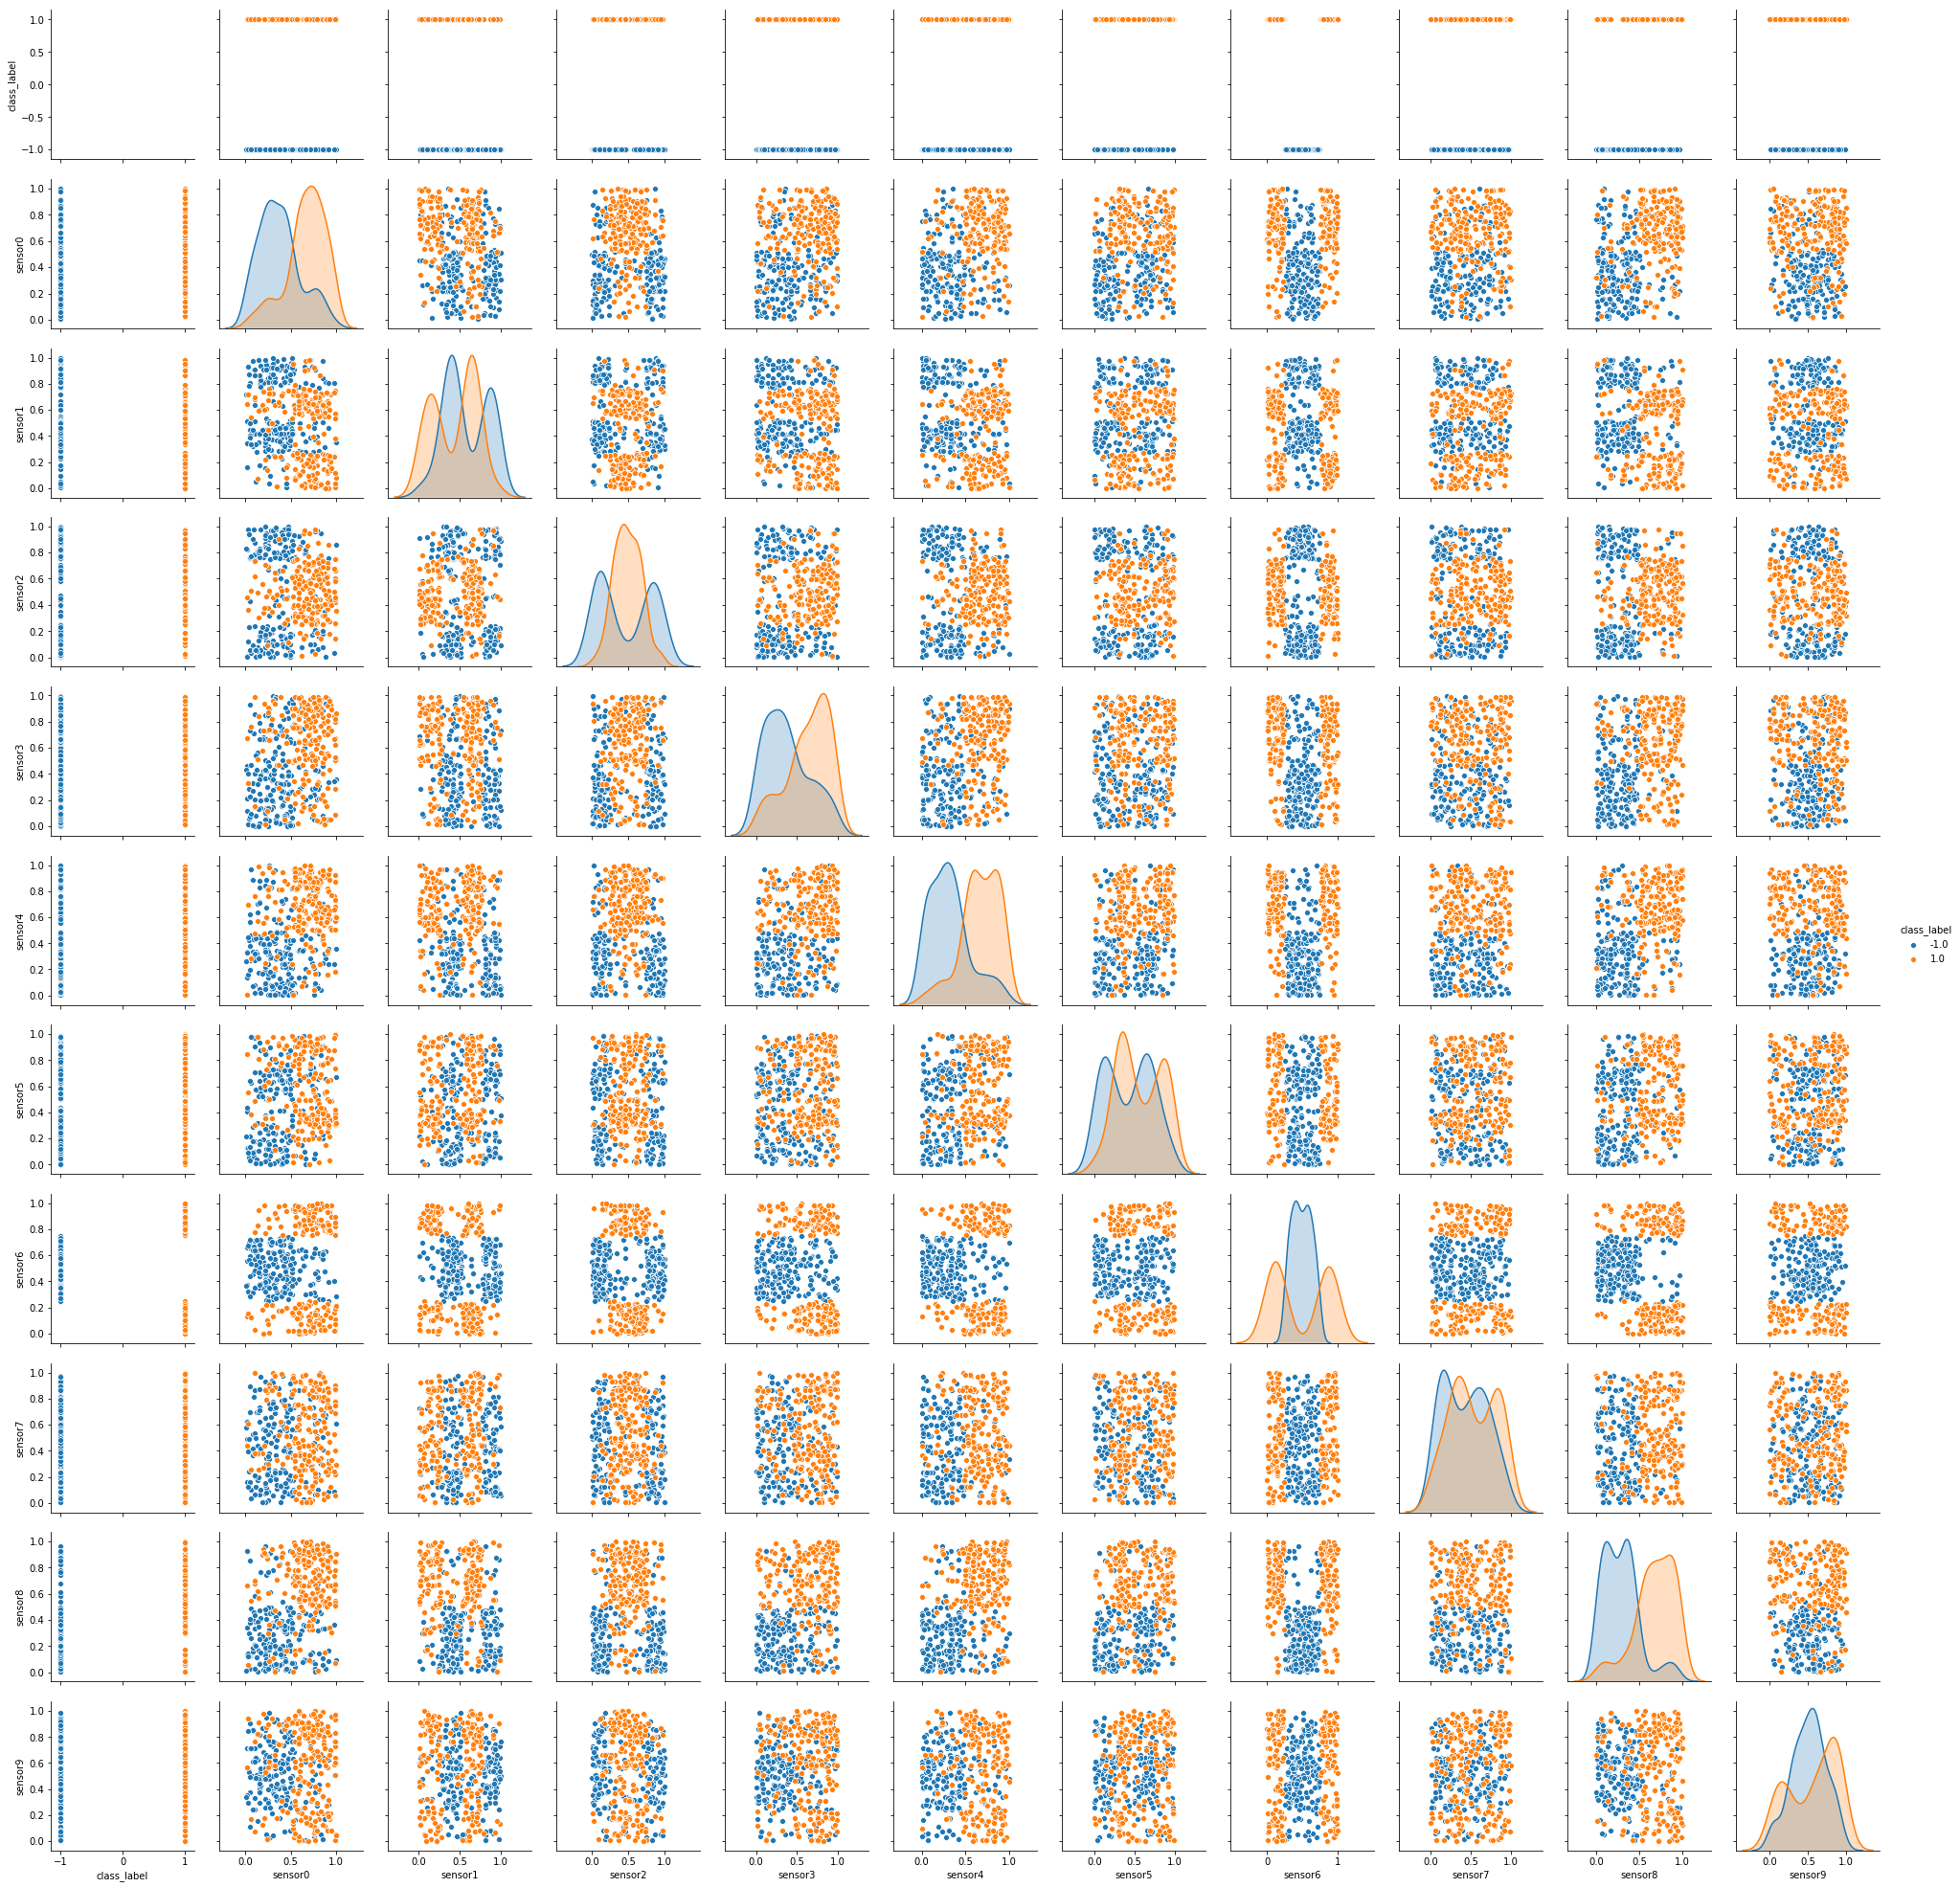

In [20]:
sns.pairplot(data=df, hue='class_label')

After analysing pairplot graph, We can see Sensor_6 is the most prdictive sensor among all others.

Other sensors like Sensor0, Sensor8 etc. are unable to predict class alone but are able to predict outcome if combine two sensors reading. As we can see from pair plot graph above sensor8 is able to predict outcome with sensor9 with less overlap of different class and so on. 

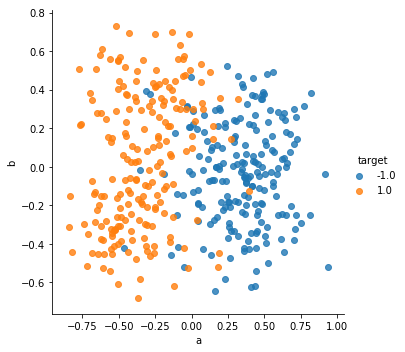

In [14]:
# We visualize the first two principal components.
data = PCA(n_components=2).fit_transform(x)
temp = pd.DataFrame(data, columns=['a', 'b'])
temp['target'] = y
sns.lmplot('a', 'b', data=temp, hue='target', fit_reg=False)

We can see from above graph that our data is balanced with less overlapping. Now we can check our model performance with different classification algorithms. 

# Model training and Scoring

In [21]:
classifiers = [('rfg', RandomForestClassifier(n_jobs=-1, criterion='gini')),
               ('rfe', RandomForestClassifier(n_jobs=-1, criterion='entropy')),
               ('extf', ExtraTreesClassifier(n_jobs=-1)),
               ('knn', KNeighborsClassifier(n_jobs=-1)),
               ('dt', DecisionTreeClassifier()),
               ('Et', ExtraTreeClassifier()),
               ('Logit', LogisticRegression()),
               ('gnb', GaussianNB()),
               ('bnb', BernoulliNB()),
              ]
allscores = []
for name, classifier in classifiers:
    scores = []
    for i in range(3): # three runs
        roc = cross_val_score(classifier, x, y, scoring='roc_auc', cv=20)
        scores.extend(list(roc))
    scores = np.array(scores)
    print(name, scores.mean())
    new_data = [(name, score) for score in scores]
    allscores.extend(new_data)
        

rfg 0.9955833333333334
rfe 0.9987499999999999
extf 0.9960000000000001
knn 0.9900000000000001
dt 0.9583333333333335
Et 0.8891666666666665
Logit 0.9675
gnb 0.9934999999999998
bnb 0.5


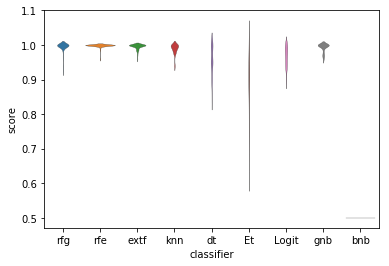

In [22]:
temp = pd.DataFrame(allscores, columns=['classifier', 'score'])
sns.violinplot('classifier', 'score', data=temp, inner=None, linewidth=0.3)

Every classifier has good performance except Bernoullie Navie Bias. Random Forest Classifier will be the best classifier here because it has high ROCAUC and low variation in the CV.

In [23]:
classifier = RandomForestClassifier(n_jobs=-1, n_estimators=100)
rfecv = RFECV(estimator=classifier, cv=15, scoring='roc_auc')
rfecv.fit(x, y)
print("Optimal number of features : {}".format(rfecv.n_features_))

Optimal number of features : 1


As we get only one Optimal number of feature here using Feature ranking and cross-validated selection method which is Sensor6. We have already analyze it from our Pairplot graph above and all other sensor need atlest one another sensor reading to predict the class.

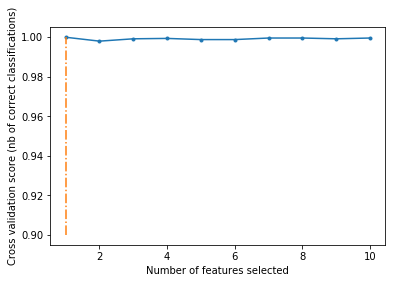

In [27]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, '.-')
plt.plot([rfecv.n_features_, rfecv.n_features_], [0.9, 1], '-.')
plt.show()

We can get the maximum score from one sensor reading only. We'll ranking all sensor with its predictive power using Ranking method of RFECV for each feature/Sensor.

In [28]:
ranks = list(zip(rfecv.ranking_, x.columns))
ranks.sort()
ranks

[(1, 'sensor6'),
 (2, 'sensor8'),
 (3, 'sensor4'),
 (4, 'sensor0'),
 (5, 'sensor2'),
 (6, 'sensor3'),
 (7, 'sensor1'),
 (8, 'sensor5'),
 (9, 'sensor9'),
 (10, 'sensor7')]

Woohoo!!!! We have our Sensor ranking ready based on its importance/predictive powerwith. Sensor6 is the most prdictive one and sensor7 is the least predictive powerwith. 